## Training a Semantic Segmentation model on the MaSTr1325 Dataset

### https://box.vicos.si/borja/viamaro/index.html#references

### Import relevent packages

In [1]:
import numpy as np
import random
import sys
import skimage.io
from PIL import Image
import cv2
#import segmentation_models as sm
import matplotlib.image as mpimg
import glob
from PIL import Image
import scipy.io as sio
import numpy
import glob
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from keras.utils import plot_model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, SpatialDropout2D, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import model_to_dot, plot_model
from tensorflow import keras
import extcolors
from colormap import rgb2hex
import pandas as pd
from PIL import ImageColor


### Define helper functions from CAB420

In [2]:
def mask_to_categorical(im, num_classes):    
    one_hot_map = []
    for i in range(num_classes):
        class_map = tf.reduce_all(tf.equal(im, i+1), axis=-1)
        one_hot_map.append(class_map)
    one_hot_map = tf.stack(one_hot_map, axis=-1)
    one_hot_map = tf.cast(one_hot_map, tf.float32)    
    return one_hot_map

def categorical_to_mask(im):
    mask = tf.dtypes.cast(tf.argmax(im, axis=2), 'float32') / 255.0
    return mask

def random_crop(img_x, img_y, random_crop_size):

    height, width = img_x.shape[0], img_x.shape[1]
    dy, dx = random_crop_size
    x = numpy.random.randint(0, width - dx + 1)
    y = numpy.random.randint(0, height - dy + 1)
    return img_x[y:(y+dy), x:(x+dx), :], img_y[y:(y+dy), x:(x+dx), :]

def crop_generator(batches, crop_length):
    """Take as input a Keras ImageGen (Iterator) and generate random
    crops from the image batches generated by the original iterator.
    """
    while True:
        batch_x, batch_y = next(batches)
        batch_crops_x = numpy.zeros((batch_x.shape[0], crop_length, crop_length, 3))
        batch_crops_y = numpy.zeros((batch_x.shape[0], crop_length, crop_length, 1))
        for i in range(batch_x.shape[0]):
            batch_crops_x[i], batch_crops_y[i] = random_crop(batch_x[i], batch_y[i], (crop_length, crop_length))
        yield (batch_crops_x, mask_to_categorical(batch_crops_y, 5))
        
def focal_loss(target, output, gamma=2):
    output /= K.sum(output, axis=-1, keepdims=True)
    eps = K.epsilon()
    output = K.clip(output, eps, 1. - eps)
    return -K.sum(K.pow(1. - output, gamma) * target * K.log(output), axis=-1)

def scheduler(epoch, lr):
    if epoch < 15:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

def create_callbacks():
    #scheduler_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=25, verbose=0, mode='auto', restore_best_weights=True)
    return [early_stopping]#[scheduler_callback, early_stopping]

def create_optimiser():
    return tf.keras.optimizers.Adam()
steps_per_epoch = 100
epochs = 50

def visualise(model, test_data, test_gt):
    pred = model.predict(test_data)
    fig = plt.figure(figsize=[20, 25])
    for i,img in enumerate(test_data):
        if (i < 32):
            ax = fig.add_subplot(8, 8, i*2 + 1)
            ax.imshow(img)
            ax = fig.add_subplot(8, 8, i*2 + 2)
            ax.imshow(categorical_to_mask(pred[i,:,:,:]))  

### Import all the data

In [3]:
def load_mask_files(path, target_size, scale_factor):    
    image_list = []
    filenames = glob.glob(path)
    filenames.sort()
    print(filenames)
    #filenames = (filenames.split("m")[0] + ".png")
    for filename in filenames:
        im = Image.open(filename)
        w, h = im.size
        im = im.resize((target_size, target_size))
        im=numpy.asarray(im) / scale_factor
        image_list.append(im)
    return numpy.asarray(image_list)

In [4]:
def load_image_files(path, target_size):    
    image_list = []
    filenames = glob.glob(path)
    filenames.sort()
    #filenames.sort(key=lambda f: int(filter(str.isdigit, f)))
    #print(filenames)
    for filename in filenames:
        image = cv2.imread(filename)
        image = cv2.resize(image, (target_size, target_size))

        #hsvImage = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        image_list.append(image)
    return numpy.asarray(image_list)

### Define custom train and test data split

In [5]:
def train_test_split_custom(images, masks):

    train_images = []
    test_images = []
    train_masks = []
    test_masks = []

    iteration_check = 0

    for i in range(len(images)):

        if (iteration_check == 4):
            test_images.append(images[i])
            test_masks.append(masks[i])
            iteration_check = 0
        else:
            train_images.append(images[i])
            train_masks.append(masks[i])
            iteration_check += 1

    train_masks = np.array(train_masks)
    test_masks = np.array(test_masks)
    train_images = np.array(train_images)
    test_images = np.array(test_images)
    
    return train_images, test_images, train_masks, test_masks

## Get colours from other dataset

In [6]:
video_paths = ["Videos/Boey.avi", "Videos/buildings.avi", "Videos/lotsOfFarAwayBoats.avi", "Videos/massiveBoat.avi", "Videos/originalBest.avi", "Videos/planeAnomaly.avi", "Videos/tinyBoatInBackground.avi", "Videos/TinyObjectInWater.avi", "Videos/tinyPlane.avi"]

In [7]:
i = 1
for video in video_paths:
    capture = cv2.VideoCapture(video)
    # Read first frame
    success, frame = capture.read()
    cv2.imwrite("Videos/" + str(i) +".jpg", frame)
    i += 1

In [25]:
def color_to_df(input):
    colors_pre_list = str(input).replace('([(','').split(', (')[0:-1]
    df_rgb = [i.split('), ')[0] + ')' for i in colors_pre_list]
    df_percent = [i.split('), ')[1].replace(')','') for i in colors_pre_list]

    #convert RGB to HEX code
    df_color_up = [rgb2hex(int(i.split(", ")[0].replace("(","")),int(i.split(", ")[1]),
    int(i.split(", ")[2].replace(")",""))) for i in df_rgb]

    df = pd.DataFrame(zip(df_color_up, df_percent), columns = ['c_code','occurence'])
    return df

In [26]:
combined_sky_df = pd.DataFrame()
combined_water_df = pd.DataFrame()
combined_other_df = pd.DataFrame()

for i in range(9):
    colours_sky = extcolors.extract_from_path('Videos/Images/Sky/' + str(i+1) + '.jpg', tolerance = 4, limit = 4)
    colours_water = extcolors.extract_from_path('Videos/Images/Water/' + str(i+1) + '.jpg', tolerance = 4, limit = 4)
    colours_other = extcolors.extract_from_path('Videos/Images/Other/' + str(i+1) + '.jpg', tolerance = 3, limit = 3)
    colours_sky_df = color_to_df(colours_sky)
    colours_water_df = color_to_df(colours_water)
    colours_other_df = color_to_df(colours_other)

    combined_sky_df = combined_sky_df.append(colours_sky_df)
    combined_water_df = combined_water_df.append(colours_water_df)
    combined_other_df = combined_other_df.append(colours_other_df)

C:\Users\User\AppData\Local\Temp\ipykernel_10800\1390868030.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_sky_df = combined_sky_df.append(colours_sky_df)
C:\Users\User\AppData\Local\Temp\ipykernel_10800\1390868030.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_water_df = combined_water_df.append(colours_water_df)
C:\Users\User\AppData\Local\Temp\ipykernel_10800\1390868030.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_other_df = combined_other_df.append(colours_other_df)
C:\Users\User\AppData\Local\Temp\ipykernel_10800\1390868030.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_

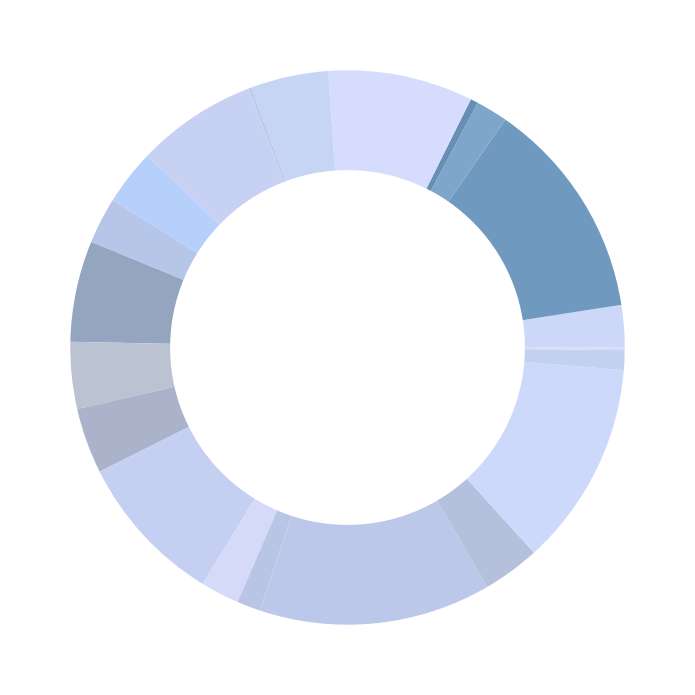

In [29]:
list_color = list(combined_sky_df['c_code'])
list_precent = [int(i) for i in list(combined_sky_df['occurence'])]
text_c = [c + ' ' + str(round(p*100/sum(list_precent),1)) +'%' for c, p in zip(list_color,
                                                                               list_precent)]
fig, ax = plt.subplots(figsize=(90,90),dpi=10)
wedges, text = ax.pie(list_precent,

                      colors = list_color,
                      textprops={'fontsize': 120, 'color':'black'}
                     )
plt.setp(wedges, width=0.3)

#create space in the center
plt.setp(wedges, width=0.36)

ax.set_aspect("equal")
fig.set_facecolor('white')
plt.show()


In [28]:
list_color_sky = list(combined_sky_df['c_code'])
list_color_water = list(combined_water_df['c_code'])
list_color_other = list(combined_other_df['c_code'])
print(list_color_sky)
print(list_color_water)
print(list_color_other)

['(205, 216, 248)', '(111, 153, 191)', '(126, 166, 202)', '(103, 142, 181)', '(214, 220, 254)', '(198, 213, 244)', '(188, 201, 233)', '(199, 209, 244)', '(183, 207, 251)', '(182, 198, 232)', '(148, 165, 191)', '(187, 194, 210)', '(171, 179, 202)', '(197, 207, 242)', '(213, 218, 248)', '(184, 197, 229)', '(187, 200, 234)', '(181, 192, 220)', '(176, 191, 212)', '(204, 217, 251)', '(194, 209, 238)', '(217, 218, 249)']
['(78, 121, 138)', '(98, 134, 156)', '(109, 145, 169)', '(67, 103, 135)', '(57, 93, 125)', '(77, 113, 145)', '(111, 144, 161)', '(122, 155, 172)', '(101, 134, 149)', '(108, 156, 170)', '(114, 161, 181)', '(100, 147, 165)', '(78, 130, 152)', '(86, 137, 164)', '(73, 126, 142)', '(76, 111, 117)', '(89, 120, 125)', '(64, 101, 109)', '(110, 139, 155)', '(121, 148, 167)', '(133, 158, 178)', '(93, 115, 138)', '(111, 131, 156)', '(83, 105, 128)', '(104, 139, 159)', '(93, 128, 147)', '(115, 150, 172)']
['(255, 208, 76)', '(248, 208, 87)', '(30, 37, 66)', '(94, 38, 63)', '(255, 254, 2

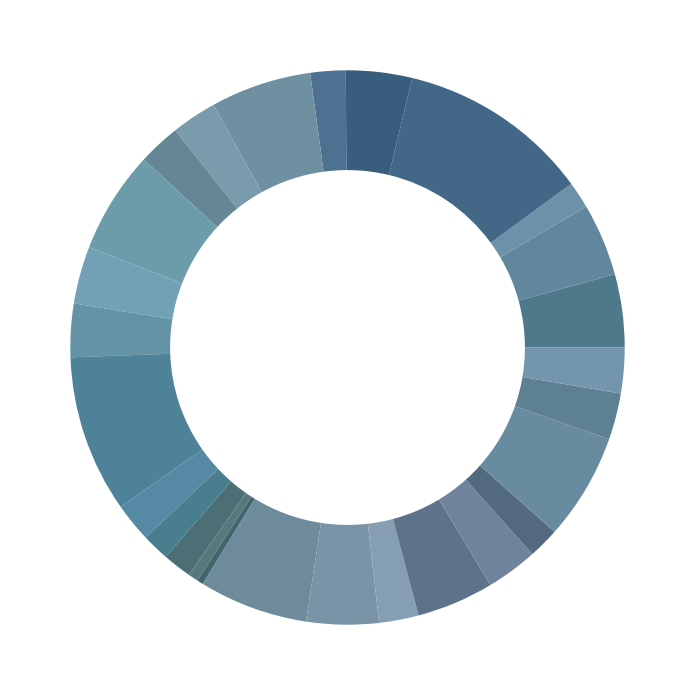

In [30]:
list_color = list(combined_water_df['c_code'])
list_precent = [int(i) for i in list(combined_water_df['occurence'])]
text_c = [c + ' ' + str(round(p*100/sum(list_precent),1)) +'%' for c, p in zip(list_color,
                                                                               list_precent)]
fig, ax = plt.subplots(figsize=(90,90),dpi=10)
wedges, text = ax.pie(list_precent,
                    #   labels= text_c,
                    #   labeldistance= 1.05,
                      colors = list_color,
                      textprops={'fontsize': 120, 'color':'black'}
                     )
plt.setp(wedges, width=0.3)

#create space in the center
plt.setp(wedges, width=0.36)

ax.set_aspect("equal")
fig.set_facecolor('white')
plt.show()

In [74]:
print(list_color_sky)

['(205, 216, 248)', '(111, 153, 191)', '(126, 166, 202)', '(103, 142, 181)', '(214, 220, 254)', '(198, 213, 244)', '(188, 201, 233)', '(199, 209, 244)', '(183, 207, 251)', '(182, 198, 232)', '(148, 165, 191)', '(187, 194, 210)', '(171, 179, 202)', '(197, 207, 242)', '(213, 218, 248)', '(184, 197, 229)', '(187, 200, 234)', '(181, 192, 220)', '(176, 191, 212)', '(204, 217, 251)', '(194, 209, 238)', '(217, 218, 249)']


In [88]:
print(list(list_color_water))

['(78, 121, 138)', '(98, 134, 156)', '(109, 145, 169)', '(67, 103, 135)', '(57, 93, 125)', '(77, 113, 145)', '(111, 144, 161)', '(122, 155, 172)', '(101, 134, 149)', '(108, 156, 170)', '(114, 161, 181)', '(100, 147, 165)', '(78, 130, 152)', '(86, 137, 164)', '(73, 126, 142)', '(76, 111, 117)', '(89, 120, 125)', '(64, 101, 109)', '(110, 139, 155)', '(121, 148, 167)', '(133, 158, 178)', '(93, 115, 138)', '(111, 131, 156)', '(83, 105, 128)', '(104, 139, 159)', '(93, 128, 147)', '(115, 150, 172)']


In [6]:
# Create Total sky colour pallet
palette = np.array([[205, 216, 248],[111, 153, 191],[126, 166, 202], [103, 142, 181], [214, 220, 254], [198, 213, 244], [188, 201, 233], [199, 209, 244], [183, 207, 251], [182, 198, 232], [148, 165, 191], [187, 194, 210], [171, 179, 202], [197, 207, 242], [213, 218, 248], [184, 197, 229], [187, 200, 234], [181, 192, 220], [176, 191, 212], [204, 217, 251], [194, 209, 238], [217, 218, 249]])#[194, 210, 242])#,[173, 188, 217],[206, 218, 242], [177, 191, 220], [231, 221, 229]])

try:
    # for all colors (256*256*256) assign color from palette
    precalculatedSkyTotal = np.load('skyColourPalleteTotal.npz')['color_cube']
except:
    precalculatedSkyTotal = np.zeros(shape=[256,256,256,3])
    for i in range(256):
        print('processing',100*i/256)
        for j in range(256):
            for k in range(256):
                index = np.argmin(np.sqrt(np.sum(((palette)-np.array([i,j,k]))**2,axis=1)))
                precalculatedSkyTotal[i,j,k] = palette[index]
    np.savez_compressed('skyColourPalleteTotal', color_cube = precalculatedSkyTotal)

In [7]:
# Create Total water colour pallet
palette = np.array([[78, 121, 138], [98, 134, 156], [109, 145, 169], [67, 103, 135], [57, 93, 125], [77, 113, 145], [111, 144, 161], [122, 155, 172], [101, 134, 149], [108, 156, 170], [114, 161, 181], [100, 147, 165], [78, 130, 152], [86, 137, 164], [73, 126, 142], [76, 111, 117], [89, 120, 125], [64, 101, 109], [110, 139, 155], [121, 148, 167], [133, 158, 178], [93, 115, 138], [111, 131, 156], [83, 105, 128], [104, 139, 159], [93, 128, 147], [115, 150, 172]])

try:
    # for all colors (256*256*256) assign color from palette
    precalculatedWaterTotal = np.load('waterColourPalleteTotal.npz')['color_cube']
except:
    precalculatedWaterTotal = np.zeros(shape=[256,256,256,3])
    for i in range(256):
        print('processing',100*i/256)
        for j in range(256):
            for k in range(256):
                index = np.argmin(np.sqrt(np.sum(((palette)-np.array([i,j,k]))**2,axis=1)))
                precalculatedWaterTotal[i,j,k] = palette[index]
    np.savez_compressed('waterColourPalleteTotal', color_cube = precalculatedWaterTotal)

In [8]:

# Create Total other colour pallet
palette = np.array([[255, 208, 76], [248, 208, 87], [30, 37, 66], [94, 38, 63], [255, 254, 255], [249, 245, 246], [27, 43, 76], [18, 34, 67], [43, 1, 2], [36, 0, 0], [82, 21, 36], [255, 255, 253], [107, 130, 174], [196, 143, 169], [6, 21, 50], [12, 26, 52], [132, 117, 124], [140, 108, 121]])

try:
    # for all colors (256*256*256) assign color from palette
    precalculatedOtherTotal = np.load('otherColourPalleteTotal.npz')['color_cube']
except:
    precalculatedOtherTotal = np.zeros(shape=[256,256,256,3])
    for i in range(256):
        print('processing',100*i/256)
        for j in range(256):
            for k in range(256):
                index = np.argmin(np.sqrt(np.sum(((palette)-np.array([i,j,k]))**2,axis=1)))
                precalculatedOtherTotal[i,j,k] = palette[index]
    np.savez_compressed('otherColourPalleteTotal', color_cube = precalculatedOtherTotal)

# Test colour change

In [31]:
images = load_image_files('../Data/MaSTr1325_images/*', 480)
masks = load_mask_files('../Data/MaSTr1325_masks/*', 480, 1.0)

['../Data/MaSTr1325_masks\\0001.png', '../Data/MaSTr1325_masks\\0002.png', '../Data/MaSTr1325_masks\\0003.png', '../Data/MaSTr1325_masks\\0004.png', '../Data/MaSTr1325_masks\\0005.png', '../Data/MaSTr1325_masks\\0006.png', '../Data/MaSTr1325_masks\\0007.png', '../Data/MaSTr1325_masks\\0008.png', '../Data/MaSTr1325_masks\\0009.png', '../Data/MaSTr1325_masks\\0010.png', '../Data/MaSTr1325_masks\\0011.png', '../Data/MaSTr1325_masks\\0012.png', '../Data/MaSTr1325_masks\\0013.png', '../Data/MaSTr1325_masks\\0014.png', '../Data/MaSTr1325_masks\\0015.png', '../Data/MaSTr1325_masks\\0016.png', '../Data/MaSTr1325_masks\\0017.png', '../Data/MaSTr1325_masks\\0018.png', '../Data/MaSTr1325_masks\\0019.png', '../Data/MaSTr1325_masks\\0020.png', '../Data/MaSTr1325_masks\\0021.png', '../Data/MaSTr1325_masks\\0022.png', '../Data/MaSTr1325_masks\\0023.png', '../Data/MaSTr1325_masks\\0024.png', '../Data/MaSTr1325_masks\\0025.png', '../Data/MaSTr1325_masks\\0026.png', '../Data/MaSTr1325_masks\\0027.png', 

In [12]:
masks = numpy.reshape(masks, (numpy.shape(masks) + (1, )))
masks = tf.keras.utils.to_categorical(masks, num_classes=None)
masks = masks[:,:,:,:4]

In [33]:
for i in range(np.shape(images)[0]):
    images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)

In [47]:


fig = plt.figure(figsize=[100, 100])
ax = fig.add_subplot(1, 1, 1)
ax.imshow(images[157])

In [12]:
# Create sky colour pallet
palette = np.array([[230,228,242],[182,202,242],[206, 218, 242]])#[194, 210, 242])#,[173, 188, 217],[206, 218, 242], [177, 191, 220], [231, 221, 229]])

try:
    # for all colors (256*256*256) assign color from palette
    precalculatedSkyOriginal = np.load('skyColourPalleteOriginal.npz')['color_cube']
except:
    precalculatedSkyOriginal = np.zeros(shape=[256,256,256,3])
    for i in range(256):
        print('processing',100*i/256)
        for j in range(256):
            for k in range(256):
                index = np.argmin(np.sqrt(np.sum(((palette)-np.array([i,j,k]))**2,axis=1)))
                precalculatedSkyOriginal[i,j,k] = palette[index]
    np.savez_compressed('skyColourPalleteOriginal', color_cube = precalculatedSkyOriginal)

In [13]:
# Create water colour pallet
palette = np.array([[73, 128, 140],[66, 112, 140],[85, 132, 159]])#,[56, 105, 122], [90, 121, 152]])

try:
    # for all colors (256*256*256) assign color from palette
    precalculatedWaterOriginal = np.load('waterColourPalleteOriginal.npz')['color_cube']
except:
    precalculatedWaterOriginal = np.zeros(shape=[256,256,256,3])
    for i in range(256):
        print('processing',100*i/256)
        for j in range(256):
            for k in range(256):
                index = np.argmin(np.sqrt(np.sum(((palette)-np.array([i,j,k]))**2,axis=1)))
                precalculatedWaterOriginal[i,j,k] = palette[index]
    np.savez_compressed('waterColourPalleteOriginal', color_cube = precalculatedWaterOriginal)

In [22]:
# Create sky colour pallet 
palette = np.array([[220,234,255],[213,230,255], [106,156,204],[130,171,213], [106,150,199], [195,208,240], [189,204,245]])

try:
    # for all colors (256*256*256) assign color from palette
    precalculatedSkyOther = np.load('skyColourPallete__Other3.npz')['color_cube']
except:
    precalculatedSkyOther = np.zeros(shape=[256,256,256,3])
    for i in range(256):
        print('processing',100*i/256)
        for j in range(256):
            for k in range(256):
                index = np.argmin(np.sqrt(np.sum(((palette)-np.array([i,j,k]))**2,axis=1)))
                precalculatedSkyOther[i,j,k] = palette[index]
    np.savez_compressed('skyColourPallete__Other3', color_cube = precalculatedSkyOther)

In [23]:
# Create water colour pallet 
palette = np.array([[97,139,152],[86,133,159], [112,138,164], [59,103,141],[30,78,108], [49,95,132], [116,160,200], [95,132,140], [57,103,100], [139,165,181]])#,[56, 105, 122], [90, 121, 152]])

try:
    # for all colors (256*256*256) assign color from palette
    precalculatedWaterOther = np.load('waterColourPallete__Other3.npz')['color_cube']
except:
    precalculatedWaterOther = np.zeros(shape=[256,256,256,3])
    for i in range(256):
        print('processing',100*i/256)
        for j in range(256):
            for k in range(256):
                index = np.argmin(np.sqrt(np.sum(((palette)-np.array([i,j,k]))**2,axis=1)))
                precalculatedWaterOther[i,j,k] = palette[index]
    np.savez_compressed('waterColourPallete__Other3', color_cube = precalculatedWaterOther)

In [24]:
# Create obstacle pallet 
palette = np.array([[26,30,50],[10,23,50], [254,247,248], [133,26,30], [160,18,35], [21,32,52], [99,107,137]])#,[56, 105, 122], [90, 121, 152]])

try:
    # for all colors (256*256*256) assign color from palette
    precalculatedobstacle = np.load('obstacleColourPallete.npz')['color_cube']
except:
    precalculatedobstacle = np.zeros(shape=[256,256,256,3])
    for i in range(256):
        print('processing',100*i/256)
        for j in range(256):
            for k in range(256):
                index = np.argmin(np.sqrt(np.sum(((palette)-np.array([i,j,k]))**2,axis=1)))
                precalculatedobstacle[i,j,k] = palette[index]
    np.savez_compressed('obstacleColourPallete', color_cube = precalculatedobstacle)

In [25]:
# Create obstacle pallet 2
palette = np.array([[254,247,248], [133,26,30], [160,18,35], [254,209,71]])#,[56, 105, 122], [90, 121, 152]])

try:
    # for all colors (256*256*256) assign color from palette
    precalculatedobstacleRed = np.load('obstacleColourPalleteWithYellow.npz')['color_cube']
except:
    precalculatedobstacleRed = np.zeros(shape=[256,256,256,3])
    for i in range(256):
        print('processing',100*i/256)
        for j in range(256):
            for k in range(256):
                index = np.argmin(np.sqrt(np.sum(((palette)-np.array([i,j,k]))**2,axis=1)))
                precalculatedobstacleRed[i,j,k] = palette[index]
    np.savez_compressed('obstacleColourPalleteWithYellow', color_cube = precalculatedobstacleRed)

In [9]:
def get_view(image, mask, maskNumber, obstacleNumber):#, maskNumber, obstacleNumber, obstacleMask):

    # Determine what colour cube to use
    #if (maskNumber == 2):
    precalculatedSky = precalculatedSkyTotal
    precalculatedWater = precalculatedWaterTotal
    #else:
        #precalculatedSky = precalculatedSkyOriginal
        #precalculatedWater = precalculatedWaterOriginal
        
    # Iterate to get to each pixel
    for i in range(len(image)):
        for j in range(len(image[i])):
            if (np.argmax(mask[i][j]) == 2):

                # get the individual pixel RGB values
                indices = image[i,j]

                # pass image colors and retrieve corresponding palette color
                image[i,j] = precalculatedSky[indices[0],indices[1],indices[2]]

            elif (np.argmax(mask[i][j]) == 1):
                # get the individual pixel RGB values
                indices = image[i,j]

                # pass image colors and retrieve corresponding palette color
                image[i,j] = precalculatedWater[indices[0],indices[1],indices[2]]

            elif ((maskNumber == 2) and (np.argmax(mask[i][j]) == 0 or np.argmax(mask[i][j]) == 3)):

                indices = image[i,j]

                image[i,j] = precalculatedOtherTotal[indices[0],indices[1],indices[2]]

    return image

# start = time.time()
# result = get_view(image)
# print('Image processing: ',time.time()-start)
# Image.fromarray(result).show()

### Apply image colour change to whole dataset

In [36]:
test = images[0:20]
testm = masks[0:20]

In [14]:
maskNumber = 1
obstacleNumber = 1


for i in range(np.shape(images)[0]):
    images[i] = get_view(images[i], masks[i], maskNumber, obstacleNumber)

    if (maskNumber < 2):
        maskNumber += 1
    else:
        maskNumber = 1

    if (obstacleNumber < 6):
        obstacleNumber += 1
    else:
        obstacleNumber = 1
        
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128


KeyboardInterrupt: 

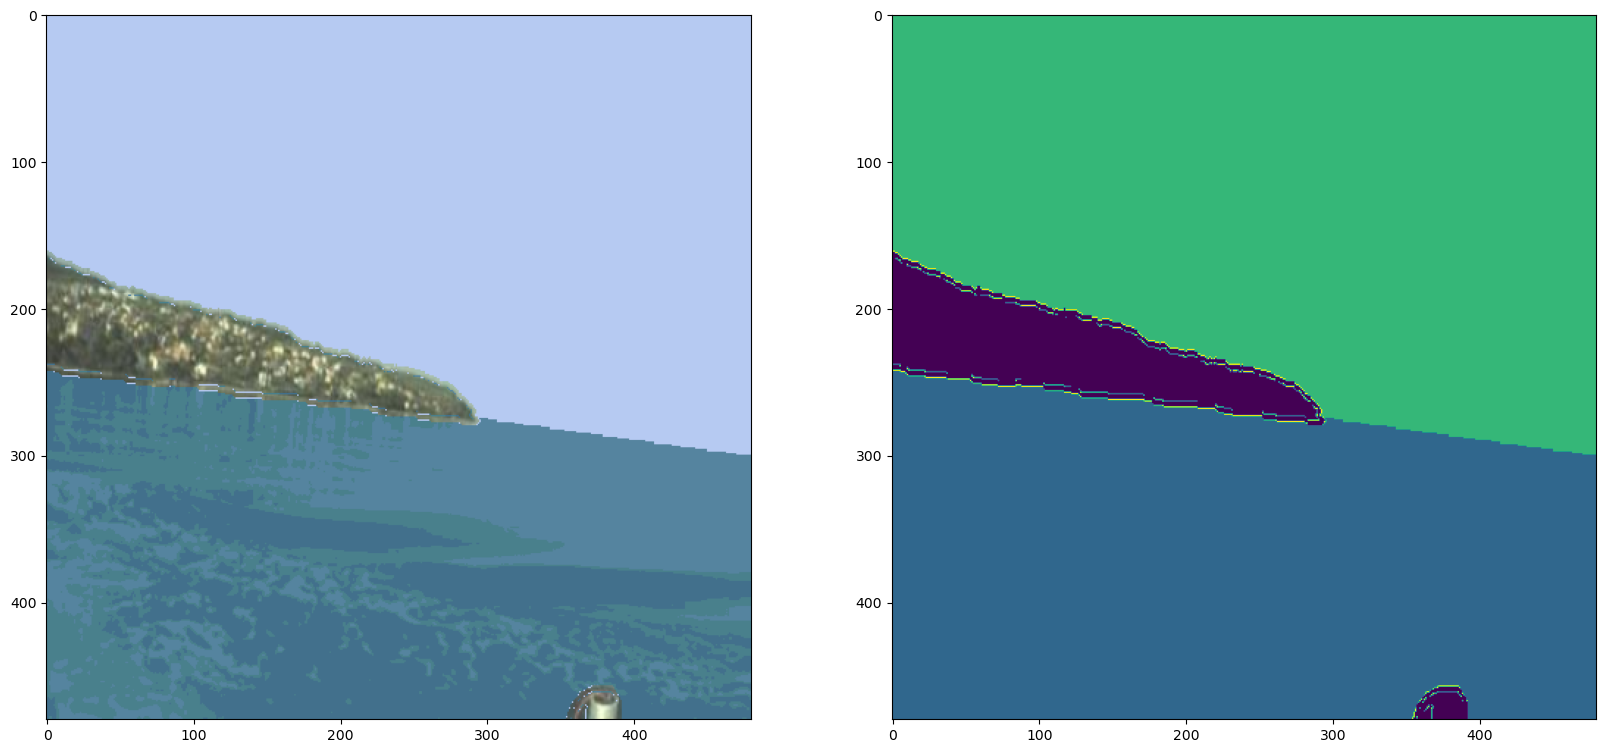

In [43]:
imageNumber=12

fig = plt.figure(figsize=[20, 25])
ax = fig.add_subplot(1, 2, 1)
ax.imshow(images[imageNumber])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(categorical_to_mask(masks[imageNumber, :, :, :]))

In [112]:
imageNumber = 100
testImage1 = images[imageNumber].copy()
testImage2 = images[imageNumber].copy()
testImage = get_view(testImage1, masks[imageNumber], 2, 1)
testImage2 = get_view(testImage2, masks[imageNumber], 2, 5)

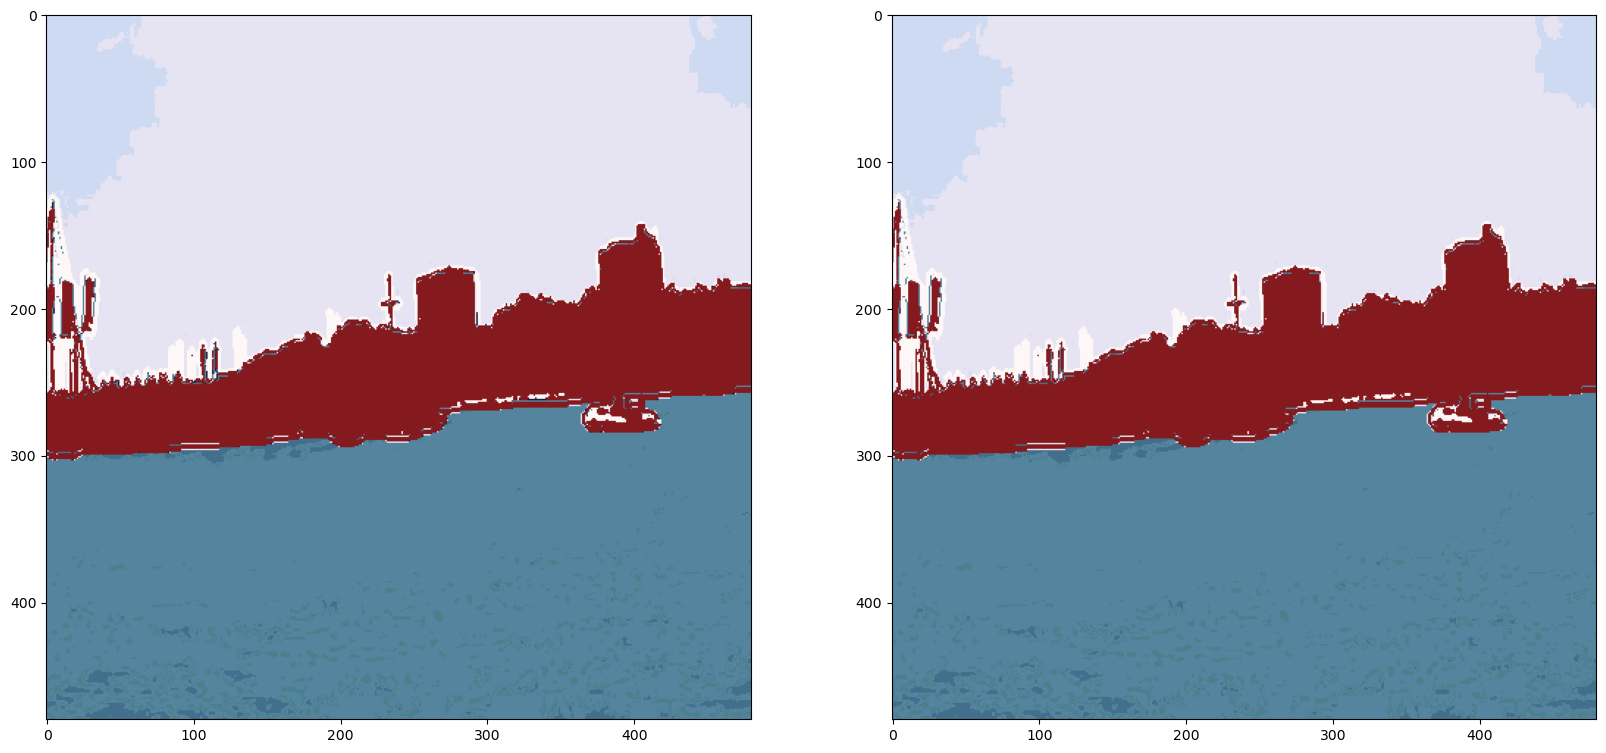

In [113]:
fig = plt.figure(figsize=[20, 25])
ax = fig.add_subplot(1, 2, 1)
ax.imshow(testImage)
ax = fig.add_subplot(1, 2, 2)
ax.imshow(testImage2)

In [103]:
# maskNumber = 3
# obstacleNumber = 1
# obstacleMask = 1

for i in range(np.shape(images)[0]):
    images[i] = get_view(images[i], masks[i])#, maskNumber, obstacleNumber, obstacleMask)

    # if (maskNumber < 3):
    #     maskNumber += 1
    # else:
    #     maskNumber = 1

    # if (obstacleNumber < 5 and maskNumber == 3):
    #     obstacleNumber += 1
    # elif obstacleNumber == 5:
    #     obstacleNumber = 1

    # obstacleMask += 1
        
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

### environment = 0, water = 1, sky = 2, ignore = 3


### Load Data and run through split

In [5]:
i = 0
for image in images:
    j = (f"{(i+1):04d}")
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    cv2.imwrite("./currentData2pmv3/" + j+".jpg", image)
    i += 1

NameError: name 'images' is not defined

In [6]:
images = load_image_files('currentData2pmv2/*', 480)
masks = load_mask_files('../Data/MaSTr1325_masks/*', 480, 1)
for i in range(len(images)):    
    images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)
masks = numpy.reshape(masks, (numpy.shape(masks) + (1, )))
masks = tf.keras.utils.to_categorical(masks, num_classes=None)
masks = masks[:,:,:,:4]

['../Data/MaSTr1325_masks\\0001.png', '../Data/MaSTr1325_masks\\0002.png', '../Data/MaSTr1325_masks\\0003.png', '../Data/MaSTr1325_masks\\0004.png', '../Data/MaSTr1325_masks\\0005.png', '../Data/MaSTr1325_masks\\0006.png', '../Data/MaSTr1325_masks\\0007.png', '../Data/MaSTr1325_masks\\0008.png', '../Data/MaSTr1325_masks\\0009.png', '../Data/MaSTr1325_masks\\0010.png', '../Data/MaSTr1325_masks\\0011.png', '../Data/MaSTr1325_masks\\0012.png', '../Data/MaSTr1325_masks\\0013.png', '../Data/MaSTr1325_masks\\0014.png', '../Data/MaSTr1325_masks\\0015.png', '../Data/MaSTr1325_masks\\0016.png', '../Data/MaSTr1325_masks\\0017.png', '../Data/MaSTr1325_masks\\0018.png', '../Data/MaSTr1325_masks\\0019.png', '../Data/MaSTr1325_masks\\0020.png', '../Data/MaSTr1325_masks\\0021.png', '../Data/MaSTr1325_masks\\0022.png', '../Data/MaSTr1325_masks\\0023.png', '../Data/MaSTr1325_masks\\0024.png', '../Data/MaSTr1325_masks\\0025.png', '../Data/MaSTr1325_masks\\0026.png', '../Data/MaSTr1325_masks\\0027.png', 

In [14]:
print(np.shape(images))
print(np.shape(masks))

(1133, 480, 480, 3)
(1133, 480, 480, 4)


In [7]:
train_images, test_images, train_masks, test_masks = train_test_split(images, masks, test_size=0.25)

In [23]:
del train_images
del test_images
del train_masks
del test_masks

In [19]:
train_images, test_images, train_masks, test_masks = train_test_split_custom(images, masks)

In [7]:
del images
del masks

In [11]:
print(np.shape(train_images))
print(np.shape(train_masks))
print(np.shape(test_images))
print(np.shape(test_masks))

(849, 480, 480, 3)
(849, 480, 480, 4)
(284, 480, 480, 3)
(284, 480, 480, 4)


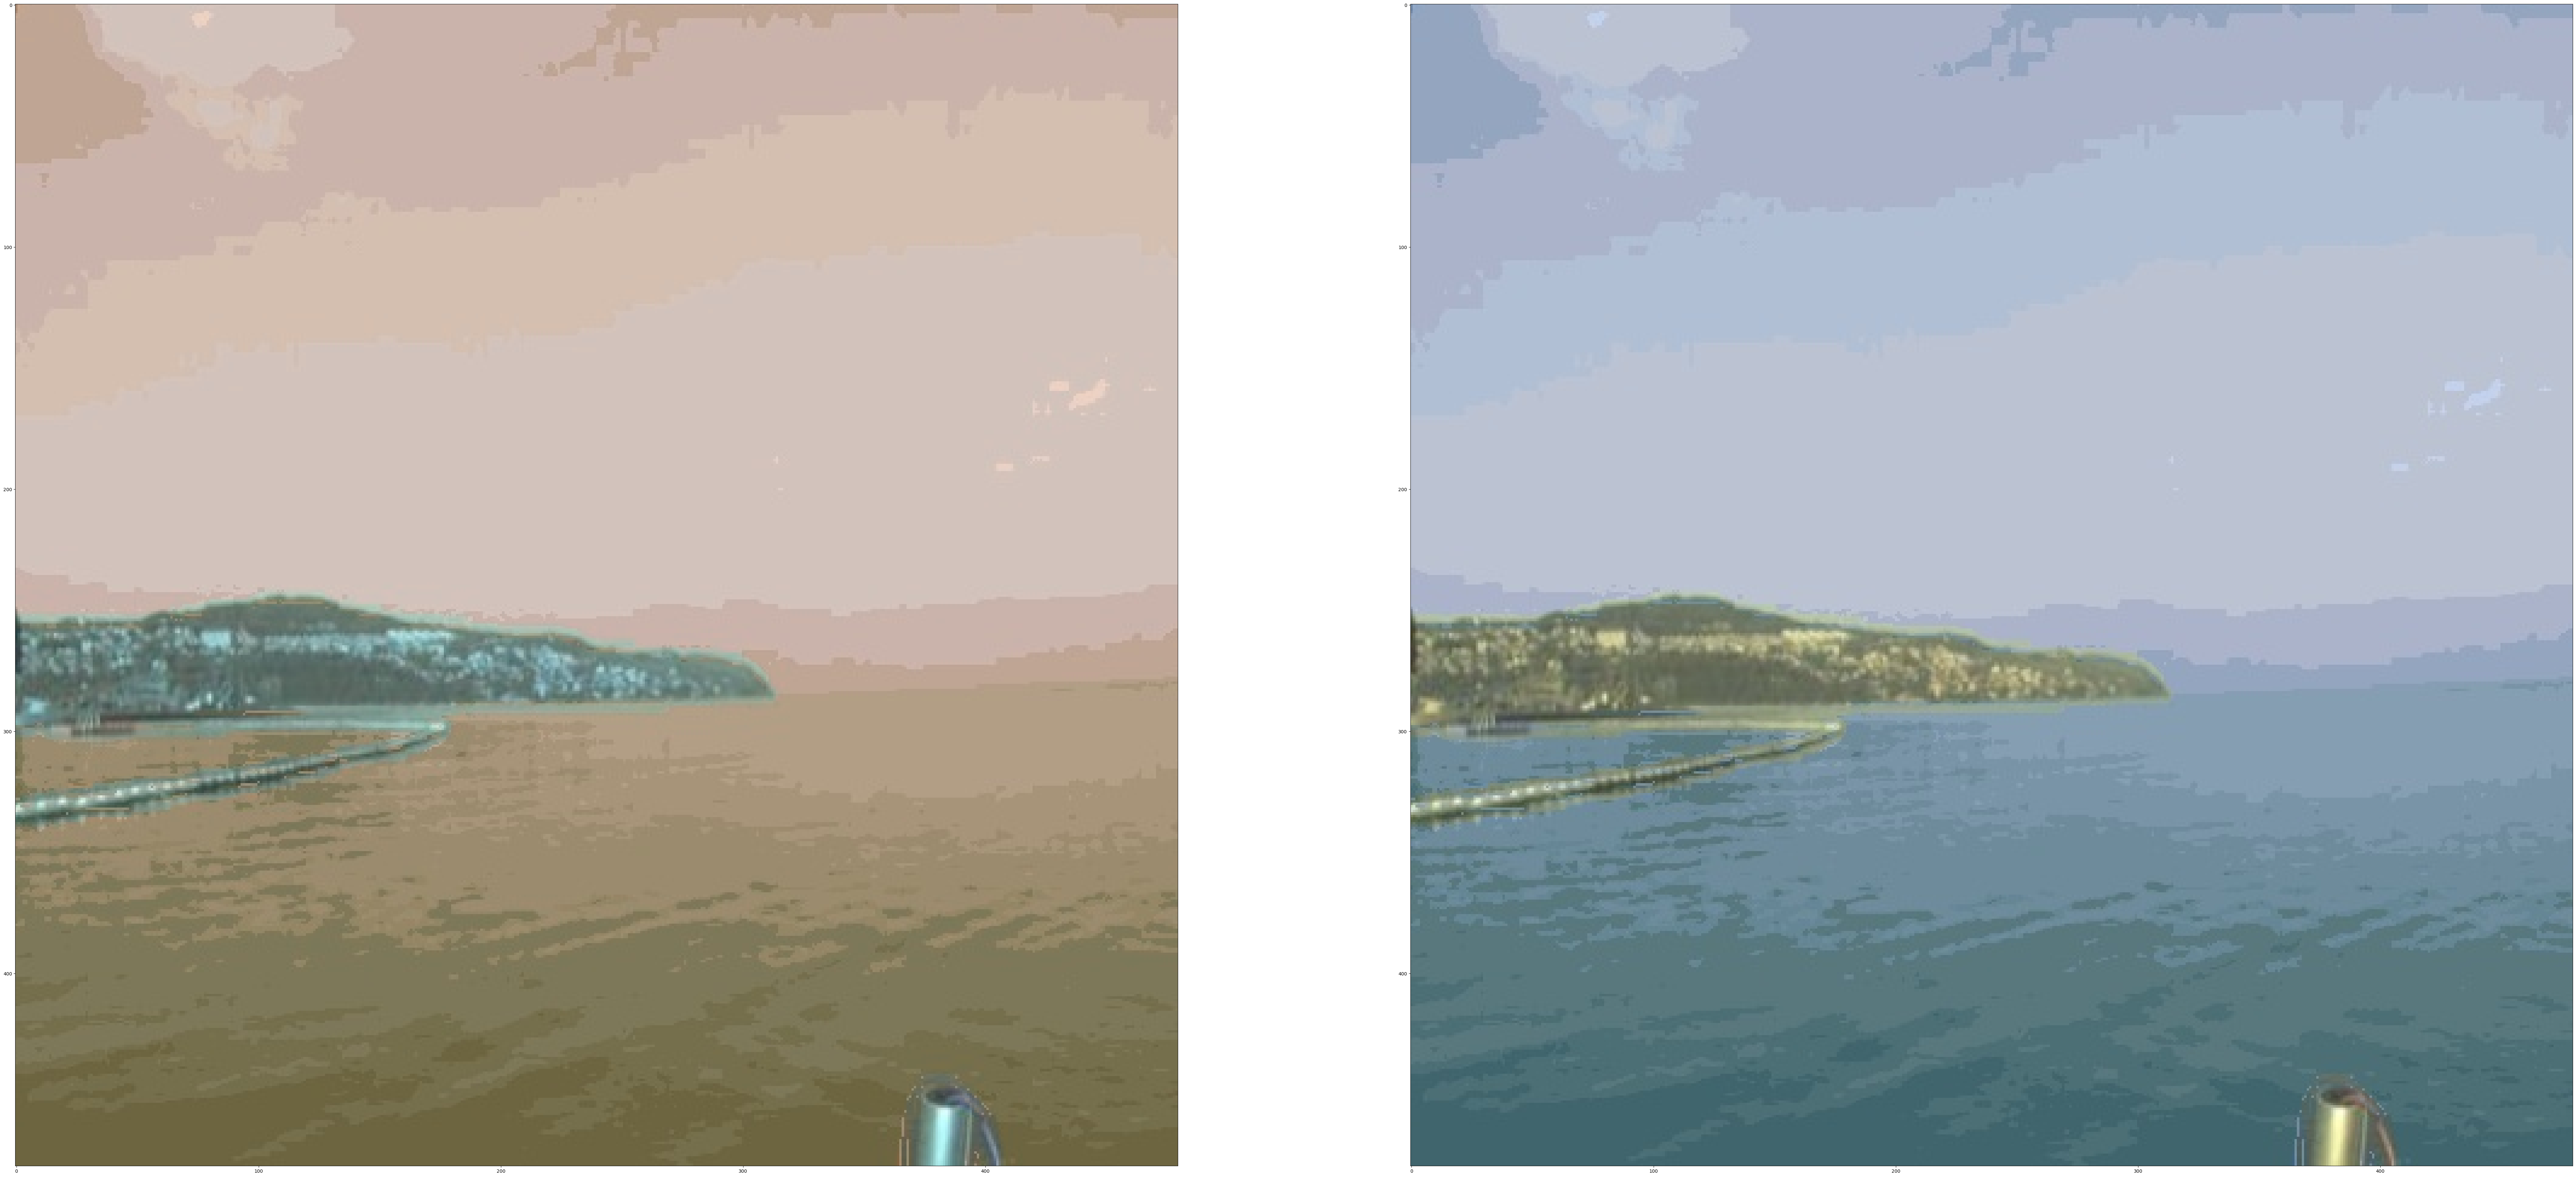

In [9]:
image_number = 431

fig = plt.figure(figsize=[100, 100])
ax = fig.add_subplot(1, 2, 1)
ax.imshow(cv2.cvtColor(train_images[image_number], cv2.COLOR_BGR2RGB))
ax = fig.add_subplot(1, 2, 2)
ax.imshow(train_images[image_number])


In [22]:
test = cv2.cvtColor(train_images[567], cv2.COLOR_BGR2RGB)

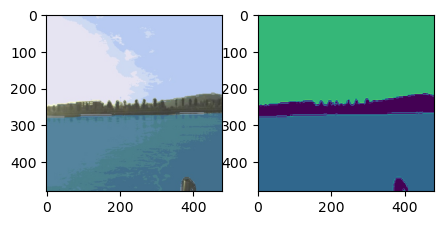

In [29]:
imageNumber=272
fig = plt.figure(figsize=[5, 5])
ax = fig.add_subplot(1, 2, 1)
ax.imshow(train_images[imageNumber])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(categorical_to_mask(train_masks[imageNumber, :, :, :]))


In [8]:
imageNumber=500

fig = plt.figure(figsize=[200, 250])
ax = fig.add_subplot(3, 3, 1)
ax.imshow(train_images[imageNumber])
ax = fig.add_subplot(3, 3, 2)
ax.imshow(train_images[imageNumber + 1])
ax = fig.add_subplot(3, 3, 3)
ax.imshow(train_images[imageNumber + 2])
ax = fig.add_subplot(3, 3, 4)
ax.imshow(train_images[imageNumber + 3])
ax = fig.add_subplot(3, 3, 5)
ax.imshow(train_images[imageNumber + 4])
ax = fig.add_subplot(3, 3, 6)
ax.imshow(train_images[imageNumber + 5])
ax = fig.add_subplot(3, 3, 7)
ax.imshow(train_images[imageNumber + 6])
ax = fig.add_subplot(3, 3, 8)
ax.imshow(train_images[imageNumber + 7])
ax = fig.add_subplot(3, 3, 9)
ax.imshow(train_images[imageNumber + 8])

In [11]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### Train U-Net on training data

In [9]:
semantic_segmentation_model = tf.keras.models.load_model('saved_model/semantic_segmentation_model_15_10_480p_loss_0018_lower_lr', compile=False)

In [9]:
semantic_segmentation_model.compile(optimizer=create_optimiser(), loss=focal_loss)
semantic_segmentation_model.fit(train_images, train_masks, batch_size= 5, epochs = 40, validation_data=(test_images, test_masks), callbacks=create_callbacks()) #validation_steps = 10

Epoch 1/40
155/155 [==============================] - 45s 139ms/step - loss: 0.0520 - val_loss: 0.0086
Epoch 2/40
155/155 [==============================] - 20s 132ms/step - loss: 0.0068 - val_loss: 0.0064
Epoch 3/40
155/155 [==============================] - 20s 132ms/step - loss: 0.0057 - val_loss: 0.0057
Epoch 4/40
155/155 [==============================] - 21s 133ms/step - loss: 0.0053 - val_loss: 0.0054
Epoch 5/40
155/155 [==============================] - 21s 134ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 6/40
155/155 [==============================] - 21s 134ms/step - loss: 0.0044 - val_loss: 0.0047
Epoch 7/40
155/155 [==============================] - 21s 135ms/step - loss: 0.0043 - val_loss: 0.0045
Epoch 8/40
155/155 [==============================] - 21s 135ms/step - loss: 0.0041 - val_loss: 0.0044
Epoch 9/40
155/155 [==============================] - 21s 136ms/step - loss: 0.0041 - val_loss: 0.0047
Epoch 10/40
155/155 [==============================] - 21s 135ms/step - l

In [8]:
semantic_segmentation_model.save('saved_model/semantic_segmentation_model_15_10_480p_loss_0018_lower_lr')

NameError: name 'semantic_segmentation_model' is not defined

In [13]:
semantic_segmentation_model_old = tf.keras.models.load_model('saved_model/semantic_segmentation_model_15_10_480p_loss_0018_lower_lr', compile=False)
semantic_segmentation_model_new = tf.keras.models.load_model('saved_model/semantic_segmentation_model_245am_0020', compile=False)

1/1 [==============================] - 0s 51ms/step


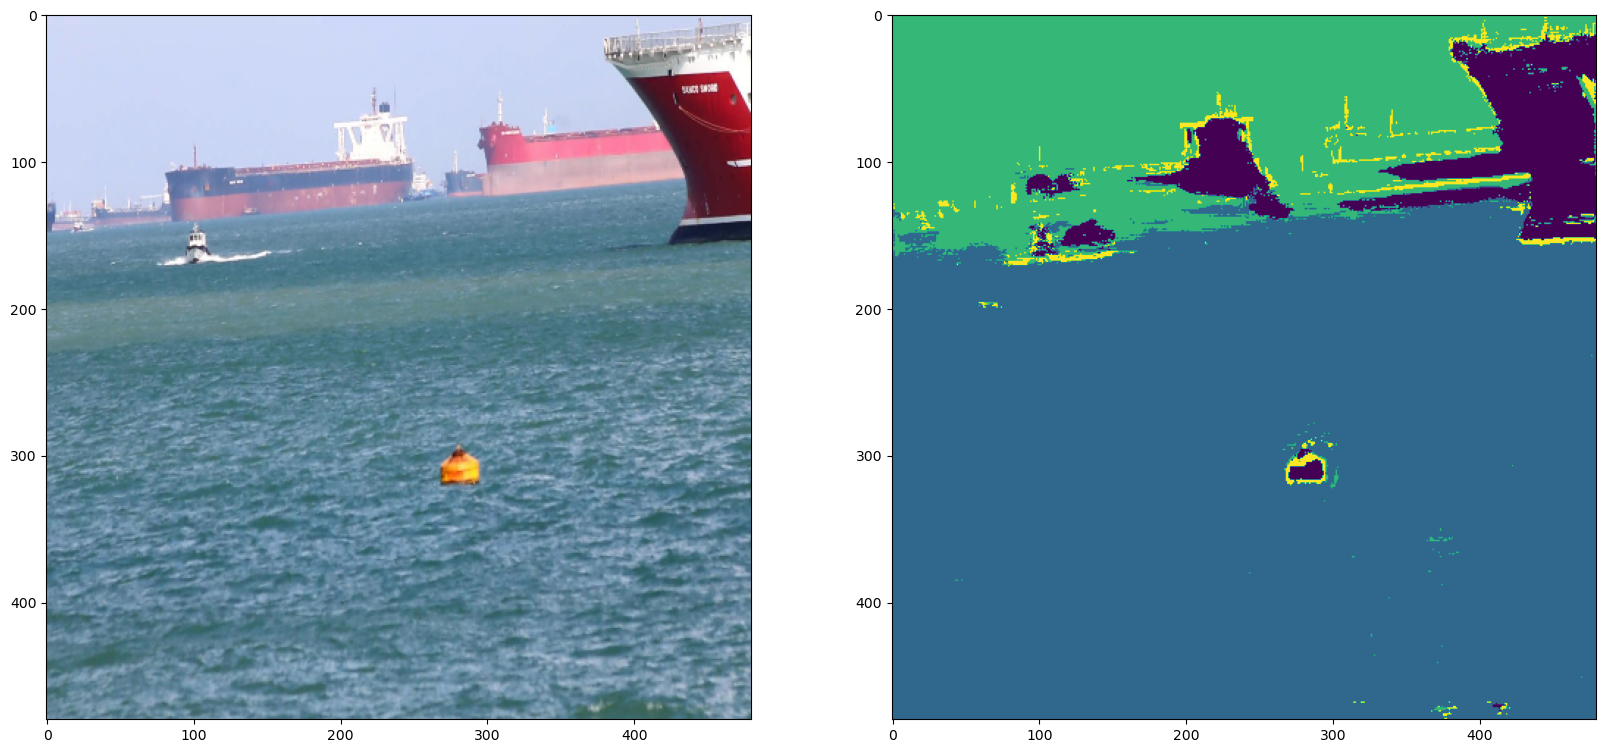

In [49]:
exampleImage = cv2.imread('./Videos/1.jpg')
#exampleImage = cv2.imread('bigBoat.jpg')
exampleImage = cv2.resize(exampleImage, (480, 480))

exampleImage = cv2.cvtColor(exampleImage, cv2.COLOR_BGR2RGB)
semantic_img_array = np.array(exampleImage)

# Expand dimensions to match the 4D Tensor shape.
semantic_img_array = np.expand_dims(semantic_img_array, axis=0)

predict = semantic_segmentation_model_old.predict(semantic_img_array)
predictNew = semantic_segmentation_model_new.predict(semantic_img_array)

fig = plt.figure(figsize=[20, 25])
ax = fig.add_subplot(1, 2, 1)
ax.imshow(exampleImage)
ax = fig.add_subplot(1, 2, 2)
ax.imshow(categorical_to_mask(predictNew[0, :, :, :]))

# fig = plt.figure(figsize=[20, 25])
# ax = fig.add_subplot(1, 3, 1)
# ax.imshow(exampleImage)
# ax = fig.add_subplot(1, 3, 2)
# ax.imshow(categorical_to_mask(predict[0, :, :, :]))
# ax = fig.add_subplot(1, 3, 3)
# ax.imshow(categorical_to_mask(predictNew[0, :, :, :]))

In [132]:
maskIntoCategoriesArray = np.round(maskIntoCategoriesArray, 4)

In [156]:
maskIntoCategories = categorical_to_mask(predict[0, :, :, :])
maskIntoCategoriesArray = np.round(maskIntoCategoriesArray, 4)
maskIntoCategoriesArray[(maskIntoCategoriesArray == 0)] = 0
maskIntoCategoriesArray[(maskIntoCategoriesArray == 0.004)] = 1
maskIntoCategoriesArray[(maskIntoCategoriesArray == 0.008)] = 2
maskIntoCategoriesArray[(maskIntoCategoriesArray == 0.012)] = 3

#### environment = 0, water = 1, sky = 2, ignore = 3


In [143]:
fig = plt.figure(figsize=[200, 250])
ax = fig.add_subplot(1, 2, 1)
ax.imshow(exampleImage)
ax = fig.add_subplot(1, 2, 2)
ax.imshow(maskIntoCategoriesArray)

In [ ]:
semantic_segmentation_model.save('saved_model/semantic_segmentation_model_15_10_480p_loss_001_lower_lr')